# Import dependencies

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

from pathlib import Path

device = torch.device("cpu")

# Define functions

In [ ]:
def f(X):
    x = X[:, 0]
    y = X[:, 1]
    return 0.1 + 0.5 * np.sin(x) + 0.3 * np.cos(y)

In [ ]:
xs = np.linspace(-np.pi, np.pi, 100)
ys = np.linspace(-np.pi, np.pi, 100)

xg, yg = np.meshgrid(xs, ys)
X = np.hstack([xg.reshape(-1, 1), yg.reshape(-1, 1)])

In [ ]:
def plot2D(func):
    s = func(X).reshape(100, 100)
    
    fig = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1.0)
    c = ax.pcolormesh(xg, yg, s, shading="nearest")
    fig.colorbar(c, ax=ax)
    plt.show()

plot2D(f)

# Approximating with quantum circuits

In [36]:
n_qubits = 4
n_layers = 1
n_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    
    qml.StronglyEntanglingLayers(weights[0], wires=range(n_qubits))
    
    for d in range(n_depth):
        for i in range(n_qubits):
            qml.RX(inputs[i % 2], wires=i)
        qml.StronglyEntanglingLayers(weights[d + 1], wires=range(n_qubits))
    
    return [qml.expval(qml.PauliZ(0))]

weight_shapes = {"weights": (n_depth + 1, n_layers, n_qubits, 3)}

In [37]:
print(qml.draw(circuit, expansion_strategy="device")(inputs=torch.arange(2),
                                                     weights=torch.rand(weight_shapes["weights"])))

0: ──Rot(0.48,0.43,0.35)─╭●───────╭X──RX(0.00)──Rot(0.49,0.06,0.81)─╭●───────╭X─┤  <Z>
1: ──Rot(0.78,0.82,0.85)─╰X─╭●────│───RX(1.00)──Rot(0.93,0.97,0.25)─╰X─╭●────│──┤     
2: ──Rot(0.36,0.18,0.93)────╰X─╭●─│───RX(0.00)──Rot(0.75,0.76,0.81)────╰X─╭●─│──┤     
3: ──Rot(0.73,0.54,0.65)───────╰X─╰●──RX(1.00)──Rot(0.99,0.34,0.08)───────╰X─╰●─┤     


In [38]:
class FreqNet(torch.nn.Module):
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.enc = torch.nn.Linear(1, 1, bias=False)
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        self.dec = torch.nn.Linear(1, 1, bias=False)
        
    def forward(self, x):
        # x = w * x
        # x = self.enc(x)
        x = self.qlayer(x).view(-1, 1)
        # x = self.dec(x)
        
        return x

In [39]:
net = FreqNet(circuit, weight_shapes)

In [44]:
def fit(net, f, epochs=100):
    
    X = torch.tensor(X).float()
    
    criterion = torch.nn.MSELoss()
    optim = torch.optim.Adam(net.parameters(), lr=0.01)
    
    x = torch.linspace(-torch.pi, torch.pi, 100)
    y_exact = f(X)
    
    for e in range(epochs):
        y_pred = net(X).flatten()
        loss = criterion(y_pred, y_exact)
        if e % 10 == 0:
            print(f"epoch: {e}, loss: {loss}")
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [139]:
fit(net, f)

/home/lurker/miniconda3/envs/torch_dde_q/lib/python3.9/site-packages/pennylane/tape/qscript.py:569: UserWarning: The get_operation will soon be updated to also return the index of the trainable operation in the tape. If you want to switch to the new behavior, you can pass `return_op_index=True`
  warnings.warn(


epoch: 0, loss: 0.0630490630865097
epoch: 10, loss: 0.05414396896958351
epoch: 20, loss: 0.045505307614803314
epoch: 30, loss: 0.03687801584601402
epoch: 40, loss: 0.027832720428705215
epoch: 50, loss: 0.017480410635471344
epoch: 60, loss: 0.006998045369982719
epoch: 70, loss: 0.005178845953196287
epoch: 80, loss: 0.0024565390776842833
epoch: 90, loss: 0.0016174123156815767


/home/lurker/miniconda3/envs/torch_dde_q/lib/python3.9/site-packages/pennylane/tape/qscript.py:569: UserWarning: The get_operation will soon be updated to also return the index of the trainable operation in the tape. If you want to switch to the new behavior, you can pass `return_op_index=True`
  warnings.warn(


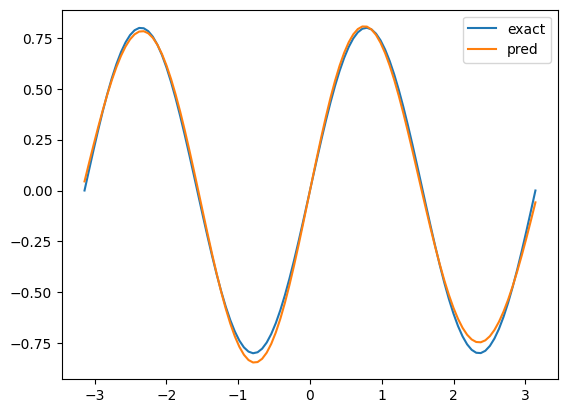

In [141]:
plot(net, f)

In [145]:
net._modules["dec"].weight

Parameter containing:
tensor([[-2.3395]], requires_grad=True)